In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import csv
import json 
import pickle
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [2]:
file = pd.read_csv("/process_file_progress_0.5.csv", header=None)
file.columns = ['comp','daynum','sent_score','sent_magn','open','close']
file.head()

,comp,daynum,sent_score,sent_magn,open,close
0,TIF,37,0.0000,0.000000,78.269997,78.279999
1,CMG,38,0.4939,0.401648,400.500000,402.940002
2,DIS,38,0.2960,0.219123,109.559998,109.000000
3,EBAY,38,-0.4215,0.328668,32.450001,33.250000
4,FB,38,-0.2732,0.200821,132.600006,134.199997


In [3]:
company_group = file.groupby(['comp'], as_index=False).apply(pd.DataFrame.sort_values, ['daynum']).reset_index()
company_group = company_group.drop(columns = ['level_0','level_1'])
company_group.head()

,comp,daynum,sent_score,sent_magn,open,close
0,A,74,0.0000,0.000000,53.430000,53.049999
1,A,80,0.3182,0.237337,52.790001,53.130001
2,A,142,0.0000,0.000000,59.799999,58.660000
3,A,198,0.7003,0.693686,61.430000,61.209999
4,A,200,0.2732,0.200821,61.450001,60.980000


In [0]:
comp_data_array = np.array(company_group)
oh_encoder = OneHotEncoder()
comp_encode = oh_encoder.fit_transform(comp_data_array[:,0:1]).toarray()
comp_encode = np.append(comp_encode, comp_data_array[:,1:],1)
comp_encode = preprocessing.normalize(comp_encode)
np.random.shuffle(comp_encode)

comp_encode_train = comp_encode[:19000,:]
comp_encode_test = comp_encode[19000:, :]

In [0]:
ds = tf.data.Dataset.from_tensor_slices(comp_encode_train)
ds = ds.window(3, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda window: window.batch(3))
ds_train = ds.shuffle(5).map(lambda window: (window[:,:-1], window[:,-1]))
#ds_train= ds.batch(2).prefetch(1)

In [0]:
ds_test = tf.data.Dataset.from_tensor_slices(comp_encode_test)
ds_test = ds_test.window(3, shift=1, drop_remainder=True)
ds_test = ds_test.flat_map(lambda window: window.batch(3))
ds_test = ds_test.shuffle(5).map(lambda window: (window[:,:-1], window[:,-1]))
#ds_test= ds_test.batch(2).prefetch(1)

In [7]:
for i,j in ds_train:
    print(i.numpy())
    print(j.numpy())
    print(i.shape)
    print(j.shape)
    break

[[ 0.          0.          0.         ...  0.          0.
   0.09655788]
 [ 0.          0.          0.         ...  0.00107859  0.00085241
   0.09877783]
 [ 0.          0.          0.         ... -0.00119557  0.00116921
   0.10134961]]
[0.09699443 0.09875367 0.09851126]
(3, 449)
(3,)


In [0]:
model = Sequential()
model.add(tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[449]))
model.add(Conv1D(32, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Conv1D(64, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))

model.compile(optimizer='sgd', metrics=['mse','mae'], loss='mse')
#model.summary(0)

In [9]:
history = model.fit(ds_train, epochs=50, verbose=2, validation_data = ds_test)

Epoch 1/50
18998/18998 - 56s - loss: 0.0069 - mse: 0.0069 - mae: 0.0600 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0384
Epoch 2/50
18998/18998 - 56s - loss: 0.0020 - mse: 0.0020 - mae: 0.0348 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0655
Epoch 3/50
18998/18998 - 57s - loss: 0.0014 - mse: 0.0014 - mae: 0.0295 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0595
Epoch 4/50
18998/18998 - 55s - loss: 0.0011 - mse: 0.0011 - mae: 0.0261 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0633
Epoch 5/50
18998/18998 - 56s - loss: 9.5128e-04 - mse: 9.5128e-04 - mae: 0.0239 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0848
Epoch 6/50
18998/18998 - 56s - loss: 8.4932e-04 - mse: 8.4932e-04 - mae: 0.0224 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0852
Epoch 7/50
18998/18998 - 55s - loss: 7.6620e-04 - mse: 7.6620e-04 - mae: 0.0212 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0700
Epoch 8/50
18998/18998 - 54s - loss: 7.1590e-04 - mse: 7.1589e-04 - mae: 0.0205 - val_l

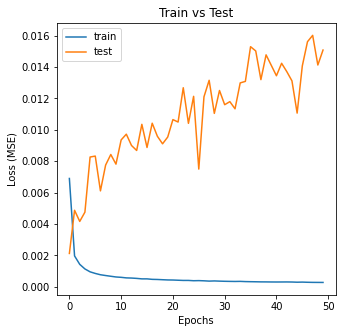

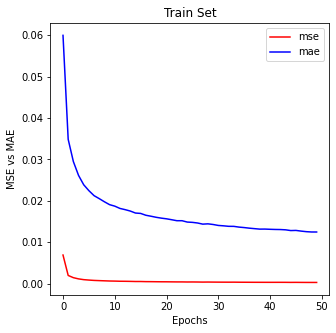

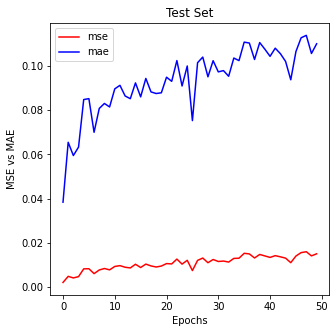

In [17]:
import matplotlib.pyplot as plt

mse = history.history['mse']
mae = history.history['mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_mse = history.history['val_mse']
val_mae = history.history['val_mae']

epochs = 50
x=[]
for i in range(epochs):
    x.append(i)

plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Test")
plt.plot(x, loss)
plt.plot(x, val_loss)
plt.legend(labels = ['train', 'test'])
plt.show()


plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("MSE vs MAE")
plt.title("Train Set")
plt.plot(x, mse, color='red')
plt.plot(x, mae, color='blue')
plt.legend(labels=['mse','mae'])
plt.show()

plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("MSE vs MAE")
plt.title("Test Set")
plt.plot(x, val_mse, color='red')
plt.plot(x, val_mae, color='blue')
plt.legend(labels=['mse','mae'])
plt.show()

In [18]:
avg_rmse = np.sqrt(np.average(val_mse))
print("RMSE on test data: ",avg_rmse)

RMSE on test data:  0.10426741531783096


In [0]:
#probably can be improved by adjusting the learning rate dynamically